361.5
320.0
0.1296875


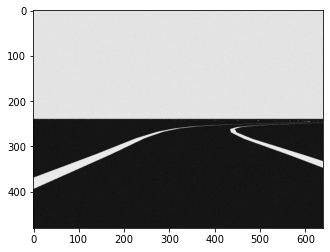

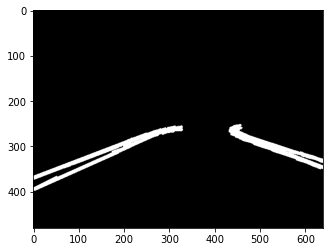

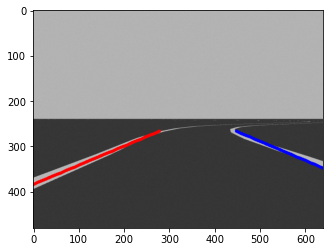

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

def draw_lines(img, lines, color=255, thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

#Read in image
og_image = cv2.imread('test2.png', 0) #Straight
#og_image = cv2.imread('test2.png', 0) #Curved right
#og_image = cv2.imread('test3.png', 0) #Curved left


#Extract dimensions and create the ROI corners before cropping image to remove horizon line
height = og_image.shape[0]
width = og_image.shape[1]

#Calculating Points for Birds-Eye Transform
imgTl = [0,0]
imgTr = [width,0]
imgBr = [width,height]
imgBl = [0,height]
img_params = np.float32([imgTl,imgTr,imgBr,imgBl])


tl = [0,height/1.8]
bl = [0, height/1.2]
tr = [width, height/1.8]
br = [width, height/1.2]
corner_points_array = np.float32([tl,tr,br,bl])

#Calculating transformation matrix and applying it to original image
#matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
#og_image = cv2.warpPerspective(og_image,matrix,(width,height))



#Calculate thresholds and apply to Canny Edge Detection
image = cv2.blur(og_image,(5,5))
lower = int(max(0,0.7*np.median(image)))
upper = int(min(255,1.3*np.median(image)))
image = cv2.Canny(image, lower, upper)

kernel = np.ones((3,3),np.uint8)
image = cv2.dilate(image,kernel,iterations = 2)

#Calculate Hough Transform to generate lines for each lane
lines = cv2.HoughLinesP(
    image,
    rho=10,
    theta=np.pi / 60,
    threshold=150,
    lines=np.array([]),
    minLineLength=10,
    maxLineGap=15
)


#Group lines into left and right and rmove any flat ones
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        if (x2 - x1) != 0:
            slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
            if math.fabs(slope) < 0.3: # <-- Only consider extreme slope
                continue
            if slope <= 0: # <-- If the slope is negative, left group.
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else: # <-- Otherwise, right group.
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])

#Use utility function to draw Hough Tranform lines onto original image
line_image = draw_lines(image, lines) # <---- Add this call.

poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))

poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))




y = np.linspace(image.shape[0]/1.8, image.shape[0])

#Formatting x and y for use with polylines to display lane overlay
left_line = np.array(list(zip(np.polyval(poly_left, y),y)), np.int32)
right_line = np.array(list(zip(np.polyval(poly_right, y),y)), np.int32)

extrap_image = cv2.polylines(cv2.cvtColor(og_image.copy(),cv2.COLOR_GRAY2RGB),[left_line], False, [255,0,0], 5)
extrap_image = cv2.polylines(extrap_image,[right_line], False, [0,0,255], 5)

left_x = int(poly_left(height))

right_x = int(poly_right(height))

avg_x = (left_x + right_x)/2

print(avg_x)

target_x = width/2

print(target_x)

error = (avg_x - target_x) / target_x

print(error)

#Showing all lines
plt.figure()
plt.imshow(og_image, 'gray')
plt.figure()
plt.imshow(line_image, 'gray')
plt.figure()
plt.imshow(extrap_image)


In [317]:
def prepareImage(img):
    '''
    Bird's eye view perspective transform followed by Canny Edge Detection.
    Return both the edge+transformed image and the transformed original image
    '''
    perspective_mat = cv2.getPerspectiveTransform(
    np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
    np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
    transform_only_img   = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img   = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.blur(img ,(5,5))
    img  = cv2.Canny(img , int(max(0,0.7*np.median(img ))), int(min(255,1.3*np.median(img ))))
    
    return img, transform_only_img 

In [318]:
def calcPositionError(left_points_sorted, right_points_sorted,img):
    if len(left_lines) > 0 and len(right_lines) > 0:
        x_left = left_points_sorted[-1][0]
        x_right = right_points_sorted[-1][0]
        avg_x = (x_left + x_right) / 2
        lane_centre = img.shape[1]/2
        error = (avg_x - lane_centre) / lane_centre
        cv2.line(img, (int(x_left), 0), (int(x_left), 480), (255,0,0), 3, cv2.LINE_AA)
        cv2.line(img, (int(x_right), 0), (int(x_right), 480), (0,0,255), 3, cv2.LINE_AA)
        cv2.line(img, (int(avg_x), 0), (int(avg_x), 480), (0,255,0), 3, cv2.LINE_AA)
        return error, img
    else:
        error = 0
        return error, img

In [319]:
def findLanes(img):
    '''
    Hough transfrom followed by sorting of detected lines to find right and left lanes.
    Returns x coordinates from left and right lane respectivley sorted by the corresponding y coordinate in ascending order.
    '''
    _lines = cv2.HoughLinesP(
    img,
    rho=10,
    theta=np.pi / 60,
    threshold=150,
    lines=np.array([]),
    minLineLength=10,
    maxLineGap=15
    )
    lines = []
    if _lines is not None:
        for i in range(len(_lines)):
            lines.append(_lines[i][0])
    lines = np.array(lines)

    left_lines = []
    right_lines = []
    lines_sorted = np.array(sorted(lines, key=lambda x: x[1]))
    left_bound = np.max(lines_sorted[:20,0])
    right_bound = np.min(lines_sorted[:20,0])
    for line in lines_sorted:
        if len(left_lines) == 0 and len(right_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(left_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(right_lines) == 0:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        else:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
    left_points = []
    right_points = []
    for i in left_lines:
        left_points.append([i[0], i[1]])
        left_points.append([i[2], i[3]])
    for i in right_lines:
        right_points.append([i[0], i[1]])
        right_points.append([i[2], i[3]])
    left_points_sorted = sorted(left_points, key=lambda x: x[1])
    right_points_sorted = sorted(right_points, key=lambda x: x[1])
    return left_points_sorted, right_points_sorted

0.1421875


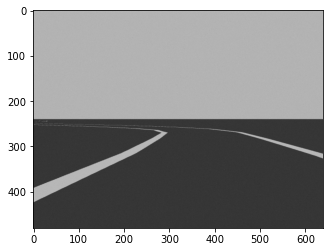

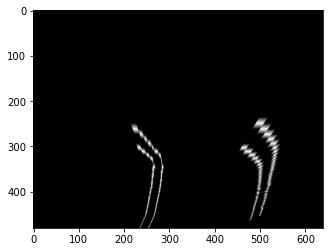

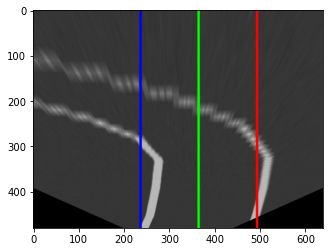

In [321]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

cv_image = cv2.imread('test3.png') #Straight

edge_img, transform_only_img = prepareImage(cv_image)


left_points_sorted, right_points_sorted = findLanes(edge_img)

error, transform_only_img = calcPositionError(left_points_sorted, right_points_sorted, transform_only_img)

print(error)
    
    
plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(processed_img,'gray')
plt.figure()
plt.imshow(transform_only_img)

In [8]:
import numpy as np
import cv2
import math
from simple_pid import PID

pid = PID(0.5, 0.01, 0.005, setpoint = np.pi)
pid.output_limits = (-0.1,0.1)

        
def prepareImage(img):
    '''
    Bird's eye view perspective transform followed by Canny Edge Detection.
    Return both the edge+transformed image and the target lane centre
    '''
    perspective_mat = cv2.getPerspectiveTransform(
    np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
    np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
    img   = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.blur(img ,(5,5))
    img  = cv2.Canny(img , int(max(0,0.7*np.median(img ))), int(min(255,1.3*np.median(img ))))
    lane_centre = img.shape[1]/2
    return img, lane_centre

def findLanes(img):
    '''
    Hough transfrom followed by sorting of detected lines to find right and left lanes.
    Returns x coordinates from left and right lane respectivley sorted by the corresponding y coordinate in ascending order.
    '''
    _lines = cv2.HoughLinesP(
    img,
    rho=10,
    theta=np.pi / 60,
    threshold=150,
    lines=np.array([]),
    minLineLength=10,
    maxLineGap=15
    )
    lines = []
    if _lines is not None:
        for i in range(len(_lines)):
            lines.append(_lines[i][0])
    lines = np.array(lines)

    left_lines = []
    right_lines = []
    lines_sorted = np.array(sorted(lines, key=lambda x: x[1]))
    left_bound = np.max(lines_sorted[:10,0])
    right_bound = np.min(lines_sorted[:10,0])
    for line in lines_sorted:
        if len(left_lines) == 0 and len(right_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(left_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(right_lines) == 0:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        else:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
    left_points = []
    right_points = []
    for i in left_lines:
        left_points.append([i[0], i[1]])
        left_points.append([i[2], i[3]])
    for i in right_lines:
        right_points.append([i[0], i[1]])
        right_points.append([i[2], i[3]])
    left_points_sorted = sorted(left_points, key=lambda x: x[1])
    right_points_sorted = sorted(right_points, key=lambda x: x[1])
    return left_points_sorted, right_points_sorted

def calcPositionError(left_points_sorted, right_points_sorted, lane_centre):
    '''
    Calculates normalized error between two detected lanes and centre to feed to a PID controller.
    '''
    if len(left_points_sorted) > 0 and len(right_points_sorted) > 0:
        x_left = left_points_sorted[-1][0]
        x_right = right_points_sorted[-1][0]
        avg_x = (x_left + x_right) / 2
        error = (avg_x - lane_centre) / lane_centre
    else:
        print("No lanes detected")
        error = 0
    return error


#cv_image = self.bridge.imgmsg_to_cv2(ros_msg,desired_encoding='bgr8')

cv_image = cv2.imread('test2.png') #Straight

processed_img, lane_centre = prepareImage(cv_image)

left_points_sorted, right_points_sorted = findLanes(processed_img)

error = calcPositionError(left_points_sorted, right_points_sorted, lane_centre)

print(error)

control = pid(error)

print(control)
            

0.1078125
0.1
